# RESEARCH QUESTION: 

In [1]:
# base modules
import os
import sys
import copy
import logging

# for manipulating data
import numpy as np
import pandas as pd
import dill
import math
from sklearn.model_selection import train_test_split

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
path_to_repo = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
path_to_repo

'/Users/filippoceccarani/Desktop/EMLyon-ML-course-2022-T1'

In [3]:
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

In [4]:
from emlyon.utils import *

In [5]:
#we took the data from https://www.fueleconomy.gov/feg/ws/ 
#https://www.epa.gov/greenvehicles/greenhouse-gas-rating 
#we have two dataframe: emissions and vehicles. we need to merge them. 
#first, we open the emissions dataframe dfe
dfe = pd.read_csv('emissions.csv')

In [6]:
np.random.seed(42)

In [7]:
#the emissison dataframe has 8 columns of dtypes: float64(2), int64(3), object(3), and 44979 rows
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44979 entries, 0 to 44978
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   efid           44979 non-null  object 
 1   id             44979 non-null  int64  
 2   salesArea      44979 non-null  int64  
 3   score          44979 non-null  float64
 4   scoreAlt       44979 non-null  float64
 5   smartwayScore  44979 non-null  int64  
 6   standard       44979 non-null  object 
 7   stdText        44965 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.7+ MB


In [8]:
#then we open the vehicles dataframe dfv
dfv = pd.read_csv('vehicles.csv')

/var/folders/x7/tm9d29mx1lv2zl6slvnz5xvw0000gn/T/ipykernel_2617/1811012411.py:2: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  dfv = pd.read_csv('vehicles.csv')


In [9]:
#the dfv has 83 columns of dtypes: bool(1), float64(32), int64(27), object(23), and 44768 rows
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44787 entries, 0 to 44786
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        44787 non-null  float64
 1   barrelsA08       44787 non-null  float64
 2   charge120        44787 non-null  float64
 3   charge240        44787 non-null  float64
 4   city08           44787 non-null  int64  
 5   city08U          44787 non-null  float64
 6   cityA08          44787 non-null  int64  
 7   cityA08U         44787 non-null  float64
 8   cityCD           44787 non-null  float64
 9   cityE            44787 non-null  float64
 10  cityUF           44787 non-null  float64
 11  co2              44787 non-null  int64  
 12  co2A             44787 non-null  int64  
 13  co2TailpipeAGpm  44787 non-null  float64
 14  co2TailpipeGpm   44787 non-null  float64
 15  comb08           44787 non-null  int64  
 16  comb08U          44787 non-null  float64
 17  combA08     

In [10]:
dfv["ghgScore"].value_counts()

-1     32012
 5      3230
 4      2590
 3      1689
 6      1678
 7      1273
 2       668
 8       610
 10      569
 1       267
 9       201
Name: ghgScore, dtype: int64

In [11]:
# Eliminated all the id duplicate for the dataframe "emission"

dfe = dfe.sort_values('id', ascending=False)
dfe = dfe.drop_duplicates(subset='id', keep='first')

In [12]:
# Eliminated all the id duplicate for the dataframe "vehicles"

dfv = dfv.sort_values('id', ascending=False)
dfv = dfv.drop_duplicates(subset='id', keep='first')

In [13]:
#the dataframes has the same id column, so we are merging the 2 dataframe based on that 
df_raw = pd.merge(left=dfe, right=dfv, left_on='id', right_on='id')

In [14]:
#shape of the new dataframe
df_raw.shape

(21950, 90)

In [15]:
df_raw.describe()

,id,salesArea,score,scoreAlt,smartwayScore,barrels08,barrelsA08,charge120,charge240,city08,...,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb
count,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.0,21950.000000,21950.000000,...,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000
mean,32950.602961,5.353121,5.033075,-0.925194,-0.578132,14.322039,0.338052,0.0,0.168935,20.527335,...,26.277834,2.082464,38.250700,1.591420,2013.437585,-4824.054670,0.032768,0.513075,0.514806,0.511617
std,7622.982502,2.165905,1.929742,0.651950,0.857135,4.048618,1.280617,0.0,1.202342,12.221939,...,17.467813,12.530751,15.057325,7.435685,5.431032,4807.963642,0.468504,5.231607,5.032342,5.108823
min,19332.000000,1.000000,-12.000000,-1.000000,-1.000000,0.047081,0.000000,0.0,0.000000,8.000000,...,9.300000,0.000000,15.100000,0.000000,2004.000000,-29500.000000,0.000000,0.000000,0.000000,0.000000
25%,25431.500000,3.000000,5.000000,-1.000000,-1.000000,11.900400,0.000000,0.0,0.000000,16.000000,...,19.300000,0.000000,30.500000,0.000000,2009.000000,-7750.000000,0.000000,0.000000,0.000000,0.000000
50%,33824.500000,7.000000,5.000000,-1.000000,-1.000000,14.167143,0.000000,0.0,0.000000,18.000000,...,23.100000,0.000000,35.980550,0.000000,2014.000000,-4250.000000,0.000000,0.000000,0.000000,0.000000
75%,39443.750000,7.000000,6.000000,-1.000000,-1.000000,16.528333,0.000000,0.0,0.000000,22.000000,...,28.000000,0.000000,42.378500,0.000000,2018.000000,-1750.000000,0.000000,0.000000,0.000000,0.000000
max,45092.000000,9.000000,10.000000,6.000000,2.000000,33.056667,16.528333,0.0,15.300000,150.000000,...,224.800000,207.262200,187.100000,173.143600,2022.000000,9750.000000,9.600000,97.000000,81.000000,88.000000


In [16]:
df_raw["ghgScore"].value_counts()

-1     9444
 5     3185
 4     2516
 6     1665
 3     1624
 7     1265
 2      653
 8      604
 10     540
 1      259
 9      195
Name: ghgScore, dtype: int64

In [17]:
df_raw["ghgScoreA"].value_counts()

-1    21259
 4      174
 3      150
 5      144
 6       90
 2       72
 1       20
 7       16
 8       13
 0       12
Name: ghgScoreA, dtype: int64

# Data Inspection

As the dataset is very technical and has a lot of column, in the data inspection we are trying to understand the relevance of each column and. 

#GENERAL CHARACTERISTICS: <br>
'make': manufacturer brand <br> 
'model': model name <br> 
'year': production year, from 2009-2018 <br> 

#ENGINE CHARACTERISTICS: <br>
'fuelType' <br>
'cylinders': engine cylinders <br>
'displ': engine displacement in liters<br>
'eng_dscr': <br> 
'phevBlended'<br>
'atvType': type of alternative fuel or advanced technology vehicle <br>

#POLLUTION: <br>
'co2TailpipeAGpm', 'co2TailpipeGpm' <br>
'co2', 'co2A'<br>
'ghgScore' <br>
'ghgScoreA' <br>

#DRIVETRAIN: <br>
'drive': <br>
'trany': <br>
'trans_dscr',<br>

#CHASSIS:   <br>
'VClass': EPA vehicle size class <br>
'pv2': 2-door passenger volume <br>
'pv4': 4-door passenger volume <br>
'lv2': 2 door luggage volume (cubic feet) <br>
'lv4': 4 door luggage volume (cubic feet) <br>
'hlv': hatchback luggage volume (cubic feet) <br>
'hpv': hatchback passenger volume (cubic feet) <br>

#ELECTRONICS: 
'tCharger':
'sCharger': 
'startStop': 

#FUEL CONSUMPTION: <br>
'city08': city MPG for fuelType1 and 2 <br>
'highway08': highway MPG for fuelType1 and 2 <br>




#all the different variable that distinuish between fuelType1 and fuelType2 can be summed up
'barrels08', 'barrelsA08': annual petroleum consumption in barrels<br>
'fuelCost08', 'fuelCostA08'
'comb08',  'combA08'
'city08', 'cityA08'
'highway08', 'highwayA08'


'standard', 
'stdText',
'trans_dscr', 
  
 
#Columns to be deleted:
efid
id
fuelType1: For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this will be the conventional fuel.
fuelType2: For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used



#Columns to be deleted becasue not relevant for the research:<br>
createdOn - date the vehicle record was created (ISO 8601 format)<br>
modifiedOn - date the vehicle record was last modified (ISO 8601 format)<br>
salesArea - The area of the country where the vehicle can legally be sold.<br>
youSaveSpend - you save/spend over 5 years compared to an average car ($). Savings are positive; a greater amount    
               spent yields a negative number. For dual fuel vehicles, this is the cost savings for gasoline <br>
guzzler - if G or T, this vehicle is subject to the gas guzzler tax <br>
city08U, cityA08U - unrounded city MPG for fuelType1 (same values as city08 but not rounded and some variable are not 
                    available)<br> 
highway08U, highwayA08U - <br>
'highwayCD','highwayE','highwayUF'- <br>
'combinedCD','combE','combinedUF' - <br>
c240Dscr - electric vehicle charger description <br>
charge240b - time to charge an electric vehicle in hours at 240 V using the alternate charger <br> 
c240bDscr - <br>
mfrCode - 3-character manufacturer code <br>
mpgData - has My MPG data <br>
phevBlended - if true, this vehicle operates on a blend of gasoline and electricity in charge depleting mode <br>
'range', 'rangeA', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA' - <br>
'score', 'scoreAlt' - <br>
'UCity', 'UCityA', 'UHighway', 'UHighwayA'- <br>
'phevCity', 'phevHwy', 'phevComb' - <br>
'smartwayScore' - <br>
'charge120' - time to charge an electric vehicle in hours at 120 V <br>
'charge240' - time to charge an electric vehicle in hours at 240 V <br>
'evMotor' - <br>
'feScore' - <br>

In [18]:
#show all columns indeces 
df_raw.columns

Index(['efid', 'id', 'salesArea', 'score', 'scoreAlt', 'smartwayScore',
       'standard', 'stdText', 'barrels08', 'barrelsA08', 'charge120',
       'charge240', 'city08', 'city08U', 'cityA08', 'cityA08U', 'cityCD',
       'cityE', 'cityUF', 'co2', 'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm',
       'comb08', 'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD',
       'combinedUF', 'cylinders', 'displ', 'drive', 'engId', 'eng_dscr',
       'feScore', 'fuelCost08', 'fuelCostA08', 'fuelType', 'fuelType1',
       'ghgScore', 'ghgScoreA', 'highway08', 'highway08U', 'highwayA08',
       'highwayA08U', 'highwayCD', 'highwayE', 'highwayUF', 'hlv', 'hpv',
       'lv2', 'lv4', 'make', 'model', 'mpgData', 'phevBlended', 'pv2', 'pv4',
       'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany',
       'UCity', 'UCityA', 'UHighway', 'UHighwayA', 'VClass', 'year',
       'youSaveSpend', 'guzzler', 'trans_dscr', 'tCharger', 'sCharger',
       'atvType', 'fuelType2', 'rangeA', 'ev

In [19]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [20]:
display_all(df_raw.describe(include = 'all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
efid,21950,6529,GPRXV04.0C91,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,21950.0,NaN,NaN,NaN,32950.602961,7622.982502,19332.0,25431.5,33824.5,39443.75,45092.0
salesArea,21950.0,NaN,NaN,NaN,5.353121,2.165905,1.0,3.0,7.0,7.0,9.0
score,21950.0,NaN,NaN,NaN,5.033075,1.929742,-12.0,5.0,5.0,6.0,10.0
scoreAlt,21950.0,NaN,NaN,NaN,-0.925194,0.65195,-1.0,-1.0,-1.0,-1.0,6.0
smartwayScore,21950.0,NaN,NaN,NaN,-0.578132,0.857135,-1.0,-1.0,-1.0,-1.0,2.0
standard,21950,48,U2,4066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stdText,21941,64,LEV-II ULEV,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
barrels08,21950.0,NaN,NaN,NaN,14.322039,4.048618,0.047081,11.9004,14.167143,16.528333,33.056667
barrelsA08,21950.0,NaN,NaN,NaN,0.338052,1.280617,0.0,0.0,0.0,0.0,16.528333


In [21]:
df_raw["make"].value_counts()

Chevrolet        1746
BMW              1620
Ford             1449
Mercedes-Benz    1224
Toyota           1065
                 ... 
Rivian              2
Fisker              1
Mahindra            1
Shelby              1
Kandi               1
Name: make, Length: 76, dtype: int64

In [22]:
df_raw["model"].value_counts()

Jetta                    105
Mustang                   98
Camaro                    92
Accord                    78
Tacoma 4WD                65
                        ... 
Titan 4WD PRO-4X           1
RAV4 Hybrid  AWD           1
RS4 Cabriolet              1
AMG GLS63 4matic Plus      1
I-Pace EV400               1
Name: model, Length: 3146, dtype: int64

In [23]:
df_raw["year"].value_counts()

2018    1340
2019    1315
2017    1281
2021    1275
2015    1268
2016    1246
2020    1245
2014    1213
2013    1170
2022    1153
2008    1129
2012    1120
2010    1071
2011    1065
2006    1056
2005    1048
2004    1040
2007     992
2009     923
Name: year, dtype: int64

In [24]:
df_raw["cylinders"].value_counts()

4.0     8143
6.0     7521
8.0     4640
12.0     488
5.0      440
3.0      194
10.0     156
2.0       28
16.0      17
Name: cylinders, dtype: int64

In [25]:
df_raw["displ"].value_counts()

2.0    3264
3.0    2149
3.5    1678
2.5    1378
2.4    1242
       ... 
0.9       6
8.3       6
2.1       5
5.8       2
0.0       1
Name: displ, Length: 62, dtype: int64

In [26]:
df_raw["phevBlended"].value_counts()

False    21752
True       198
Name: phevBlended, dtype: int64

In [27]:
df_raw["drive"].value_counts()

Front-Wheel Drive             6879
Rear-Wheel Drive              6545
All-Wheel Drive               4154
4-Wheel or All-Wheel Drive    2040
4-Wheel Drive                 1942
Part-time 4-Wheel Drive        390
Name: drive, dtype: int64

In [28]:
df_raw["atvType"].value_counts()

FFV               1303
Hybrid             906
Diesel             346
EV                 323
Plug-in Hybrid     255
CNG                 20
Bifuel (CNG)         4
Name: atvType, dtype: int64

In [29]:
df_raw["eng_dscr"].isnull().sum()

11165

In [30]:
df_raw["trans_dscr"].value_counts()

CLKUP              2521
2MODE CLKUP         555
3MODE CLKUP         414
EMS 2MODE CLKUP     293
SIL                 149
EMS                 129
CMODE               115
3MODE                80
2MODE                71
VMODE CLKUP          50
CMODE CLKUP          47
DC/FW                44
6MODE CLKUP          31
4MODE                28
2MODE 2LKUP          27
EMS CLKUP            24
VMODE VLKUP          24
VLKUP                21
CMODE VLKUP          14
SIL EMS               7
6MODE                 6
4MODE CLKUP           6
SIL 2MODE CLKUP       4
SIL 3MODE             3
3MODE VLKUP           2
LONG RATIO            2
EMS 3MODE CLKUP       2
3MODE CLKUP FW        1
SIL 3MODE CLKUP       1
Name: trans_dscr, dtype: int64

In [31]:
df_raw["model"].value_counts()

Jetta                    105
Mustang                   98
Camaro                    92
Accord                    78
Tacoma 4WD                65
                        ... 
Titan 4WD PRO-4X           1
RAV4 Hybrid  AWD           1
RS4 Cabriolet              1
AMG GLS63 4matic Plus      1
I-Pace EV400               1
Name: model, Length: 3146, dtype: int64

In [32]:
#fuelType = fuelType1 + fuelType2 
#fuelType can be deleted 
df_raw["fuelType"].value_counts()

Regular                        10338
Premium                         9223
Gasoline or E85                 1188
Diesel                           346
Electricity                      323
Midgrade                         138
Premium and Electricity          122
Premium or E85                   115
Regular Gas and Electricity       76
Premium Gas or Electricity        53
CNG                               20
Regular Gas or Electricity         4
Gasoline or natural gas            4
Name: fuelType, dtype: int64

In [33]:
#For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this will be the conventional fuel.
df_raw["fuelType1"].value_counts()

Regular Gasoline     11610
Premium Gasoline      9513
Diesel                 346
Electricity            323
Midgrade Gasoline      138
Natural Gas             20
Name: fuelType1, dtype: int64

In [34]:
#For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG).
df_raw["fuelType2"].value_counts()

E85            1303
Electricity     255
Natural Gas       4
Name: fuelType2, dtype: int64

In [35]:
#the empty value mean the vehicle only have one type of fuel 
df_raw['fuelType2'].isna().sum()

20388

In [36]:
df_raw['ghgScore'].value_counts()

-1     9444
 5     3185
 4     2516
 6     1665
 3     1624
 7     1265
 2      653
 8      604
 10     540
 1      259
 9      195
Name: ghgScore, dtype: int64

In [37]:
df_raw['ghgScoreA'].value_counts()

-1    21259
 4      174
 3      150
 5      144
 6       90
 2       72
 1       20
 7       16
 8       13
 0       12
Name: ghgScoreA, dtype: int64

In [38]:
#electric vehicle charger description
df_raw["c240Dscr"].value_counts()

standard charger    116
3.6 kW charger        4
single charger        3
7.2 kW charger        2
6.6 kW charger        2
Name: c240Dscr, dtype: int64

In [39]:
#time to charge an electric vehicle in hours at 240 V using the alternate charger
df_raw["charge240b"].value_counts()

0.00    21833
4.75       46
8.00       18
8.50       15
3.75        9
8.30        5
6.20        4
9.60        4
5.00        3
8.20        2
4.40        2
6.60        2
6.50        1
5.80        1
9.30        1
2.30        1
7.00        1
2.50        1
4.00        1
Name: charge240b, dtype: int64

In [40]:
df_raw["city08"].value_counts()

18     1956
17     1953
16     1911
19     1731
15     1702
       ... 
61        1
93        1
60        1
67        1
148       1
Name: city08, Length: 124, dtype: int64

In [41]:
#the fuel consumption in the city for fuelType2 is mainly 0 - therefore we are adding up the column 'city08' and 'cityA08'
df_raw["city08"].value_counts()

18     1956
17     1953
16     1911
19     1731
15     1702
       ... 
61        1
93        1
60        1
67        1
148       1
Name: city08, Length: 124, dtype: int64

In [42]:
#EPA 1-10 smog rating for fuelType1
#-12 and -3 are wrong values becasue the rating goes from 1 to 10 
df_raw["score"].value_counts()

 5.0     7491
 6.0     6889
 3.0     2071
 1.0     1732
 7.0     1566
 2.0      974
 9.0      646
 10.0     320
 8.0      242
-12.0      11
 4.0        5
-2.0        3
Name: score, dtype: int64

In [43]:
#EPA 1-10 smog rating for fuelType2
df_raw["scoreAlt"].value_counts()

-1.0    21623
 5.0      117
 6.0       90
 2.0       70
 1.0       50
Name: scoreAlt, dtype: int64

In [44]:
#the ghgScore reflects vehicle tailpipe emissions of carbon dioxide (CO2), the most prevalent greenhouse gas (GHG).
df_raw["ghgScore"].value_counts()

-1     9444
 5     3185
 4     2516
 6     1665
 3     1624
 7     1265
 2      653
 8      604
 10     540
 1      259
 9      195
Name: ghgScore, dtype: int64

In [45]:
df_raw["ghgScoreA"].value_counts()

-1    21259
 4      174
 3      150
 5      144
 6       90
 2       72
 1       20
 7       16
 8       13
 0       12
Name: ghgScoreA, dtype: int64

In [46]:
df_raw["VClass"].value_counts()

Midsize Cars                          2991
Compact Cars                          2880
Subcompact Cars                       2000
Large Cars                            1653
Sport Utility Vehicle - 4WD           1413
Two Seaters                           1348
Small Sport Utility Vehicle 4WD       1331
Sport Utility Vehicle - 2WD           1111
Standard Sport Utility Vehicle 4WD    1054
Minicompact Cars                       892
Small Station Wagons                   850
Standard Pickup Trucks 4WD             825
Small Sport Utility Vehicle 2WD        823
Standard Pickup Trucks 2WD             797
Standard Sport Utility Vehicle 2WD     391
Small Pickup Trucks 2WD                282
Midsize Station Wagons                 245
Minivan - 2WD                          244
Small Pickup Trucks 4WD                229
Vans, Cargo Type                       192
Special Purpose Vehicle 2WD            170
Vans, Passenger Type                   159
Special Purpose Vehicle 4WD             37
Minivan - 4

# Data Cleaning

Based on the data inspection part we are going to eliminate ...... 

In [47]:
df = df_raw

In [48]:
# Removed the column previously cited in the data inspection 

df = df.drop(["createdOn", 
              "efid","id", 
              "fuelType1", "fuelType2", 
              "createdOn", 
              "modifiedOn", 
              "salesArea", 
              "youSaveSpend", 
              "guzzler", 
              "city08U", "cityA08U", "cityCD", "cityE", "cityUF",
              "highway08U", "highwayA08U", "highwayCD", "highwayE", "highwayUF", 
              "comb08U", "combA08U", "combinedCD", "combE", "combinedUF", 
              "c240Dscr", "charge240b", "charge120", "c240bDscr", 
              "mfrCode", 
              "mpgData", 
              "phevBlended", 
              "range", "rangeA", "rangeCity", "rangeCityA", "rangeHwy", "rangeHwyA", 
              "UCity", "UCityA", "UHighway", "UHighwayA", 
              "phevCity", "phevHwy", "phevComb", 
              "smartwayScore", 
              "evMotor",  
              "fuelCost08", "fuelCostA08"
             ], axis = 1)

In [49]:
df.shape

(21950, 42)

In [50]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'barrels08', 'barrelsA08',
       'charge240', 'city08', 'cityA08', 'co2', 'co2A', 'co2TailpipeAGpm',
       'co2TailpipeGpm', 'comb08', 'combA08', 'cylinders', 'displ', 'drive',
       'engId', 'eng_dscr', 'feScore', 'fuelType', 'ghgScore', 'ghgScoreA',
       'highway08', 'highwayA08', 'hlv', 'hpv', 'lv2', 'lv4', 'make', 'model',
       'pv2', 'pv4', 'trany', 'VClass', 'year', 'trans_dscr', 'tCharger',
       'sCharger', 'atvType', 'startStop'],
      dtype='object')

In [51]:
# Create a new column " Barrels " with the sum of "barrels08" and "barrelsA08"
df['Barrels'] = df['barrels08'] + df['barrelsA08'] 

In [52]:
# Create a new column " City " with the sum of "city08" and "cityA08"
df['City'] = df['city08'] + df['cityA08']

In [53]:
# Create a new column " Co2 " with the sum of "co2" and "co2A"
df['Co2'] = df['co2'] + df['co2A']

In [54]:
# Create a new column " co2TailpipeGpm " with the sum of "co2TailpipeAGpm" and "co2TailpipeGpm"
df['co2TailpipeGpm'] = df['co2TailpipeAGpm'] + df['co2TailpipeGpm']

In [55]:
# Create a new column " Comb08 " with the sum of "comb08" and "combA08"
df['comb'] = df['comb08'] + df['combA08']

In [56]:
# Create a new column " Highway " with the sum of "highway08" and "highwayA08"
df['Highway'] = df["highway08"] + df['highwayA08'] 

In [57]:
# Removed all the columns summed and left the aggregate ones 

df = df.drop(["barrels08", "barrelsA08", "city08","cityA08", "co2", "co2A", "co2TailpipeAGpm", "co2TailpipeGpm", "comb08", "combA08", "highway08", "highwayA08"], axis = 1)

In [58]:
# Merge the columns "tCharger" and "sCharger"

df['Charger']= df['tCharger'].fillna('0') + ' ' + df['sCharger'].fillna('0')

In [59]:
df.head()

,score,scoreAlt,standard,stdText,charge240,cylinders,displ,drive,engId,eng_dscr,...,tCharger,sCharger,atvType,startStop,Barrels,City,Co2,comb,Highway,Charger
0,7.0,-1.0,T3B30,Federal Tier 3 Bin 30,0.0,6.0,3.0,4-Wheel Drive,774,SIDI; Mild Hybrid,...,NaN,NaN,Hybrid,Y,13.523182,19,407,22,26,0 0
1,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,Rear-Wheel Drive,65,SIDI & PFI; FFV,...,NaN,NaN,FFV,N,22.823088,26,1046,29,34,0 0
2,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,All-Wheel Drive,64,SIDI & PFI; FFV,...,NaN,NaN,FFV,N,23.916875,25,1089,28,32,0 0
3,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,245,SIDI,...,T,NaN,NaN,Y,13.523182,19,408,22,25,T 0
4,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,210,SIDI,...,T,NaN,NaN,Y,12.935217,20,391,23,28,T 0


In [60]:
# Removed the columns summed 

df = df.drop(["tCharger", "sCharger"], axis = 1)

In [61]:
# Rewrite the string in a better format 

df["Charger"] = df["Charger"].apply({'0 0':0, 'T 0': "T",'0 S': "S",'T S': "TS"  }.get)

In [62]:
df['Charger'].value_counts() 

0     14351
T      6842
S       674
TS       83
Name: Charger, dtype: int64

In [63]:
#eliminate the rows where ghgScore is -1 = not available 
df.drop(df[df['ghgScore'] == -1].index, inplace = True)

In [64]:
df.shape

(12506, 34)

In [65]:
#eliminate the rows where ghgScoreA is 0 = not available 
df.drop(df[df['ghgScoreA'] == 0].index, inplace = True)

In [66]:
df['ghgScoreA'].value_counts() 

-1    11815
 4      174
 3      150
 5      144
 6       90
 2       72
 1       20
 7       16
 8       13
Name: ghgScoreA, dtype: int64

In [67]:
#for FuelType1 only keep the ghgScore rating
#for FuelType2 compute the rating as the mean between ghgScore and ghgScoreA
ghgScoreonly = df[df['ghgScoreA'] == -1].index
ghgScoremean = df[df['ghgScoreA'] != -1].index 

In [68]:
df.loc[ghgScoreonly, 'ghgScoreavg'] = df.loc[ghgScoreonly,'ghgScore']
df.loc[ghgScoremean, 'ghgScoreavg'] = df.loc[ghgScoremean,['ghgScore', 'ghgScoreA']].mean(axis=1)

In [69]:
df.loc[ghgScoremean,['ghgScoreavg','ghgScore','ghgScoreA']]

,ghgScoreavg,ghgScore,ghgScoreA
1,3.0,3,3
2,3.0,3,3
183,3.5,3,4
192,4.0,4,4
194,4.5,4,5
...,...,...,...
12420,2.0,2,2
12507,5.0,5,5
12510,5.5,6,5
12527,4.0,4,4


In [70]:
df = df.drop(["ghgScore", "ghgScoreA"], axis = 1)

In [71]:
df.head()

,score,scoreAlt,standard,stdText,charge240,cylinders,displ,drive,engId,eng_dscr,...,trans_dscr,atvType,startStop,Barrels,City,Co2,comb,Highway,Charger,ghgScoreavg
0,7.0,-1.0,T3B30,Federal Tier 3 Bin 30,0.0,6.0,3.0,4-Wheel Drive,774,SIDI; Mild Hybrid,...,NaN,Hybrid,Y,13.523182,19,407,22,26,0,5.0
1,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,Rear-Wheel Drive,65,SIDI & PFI; FFV,...,NaN,FFV,N,22.823088,26,1046,29,34,0,3.0
2,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,All-Wheel Drive,64,SIDI & PFI; FFV,...,NaN,FFV,N,23.916875,25,1089,28,32,0,3.0
3,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,245,SIDI,...,NaN,NaN,Y,13.523182,19,408,22,25,T,5.0
4,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,210,SIDI,...,NaN,NaN,Y,12.935217,20,391,23,28,T,5.0


# Data Visualization

SEABORN: 
replot, scatterplot <br>

boxplot <br>
countplot <br>

https://seaborn.pydata.org/tutorial/function_overview.html 

In [72]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'charge240', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelType', 'hlv',
       'hpv', 'lv2', 'lv4', 'make', 'model', 'pv2', 'pv4', 'trany', 'VClass',
       'year', 'trans_dscr', 'atvType', 'startStop', 'Barrels', 'City', 'Co2',
       'comb', 'Highway', 'Charger', 'ghgScoreavg'],
      dtype='object')

<AxesSubplot:xlabel='Co2', ylabel='ghgScoreavg'>

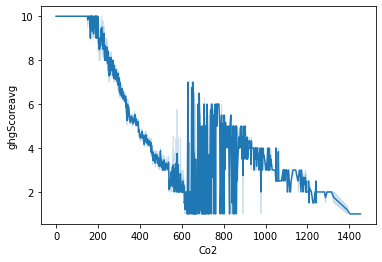

In [73]:
sns.lineplot(data=df, x="Co2", y="ghgScoreavg")

<Figure size 2160x2160 with 0 Axes>

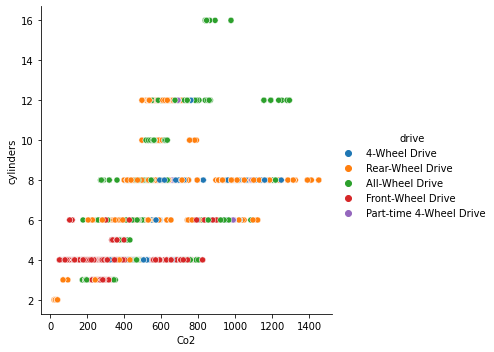

In [74]:
#from this graph we can see that as the number of cylinder increases the co2 emissions are also increasing 
#the type of drive is also influencing thsns.lineplot(data=flights, x="year", y="passengers", hue="month")e emissions 
plt.figure(figsize=(30,30))
sns.relplot(data=df, x="Co2", y="cylinders", hue='drive')

/var/folders/x7/tm9d29mx1lv2zl6slvnz5xvw0000gn/T/ipykernel_2617/2902534495.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


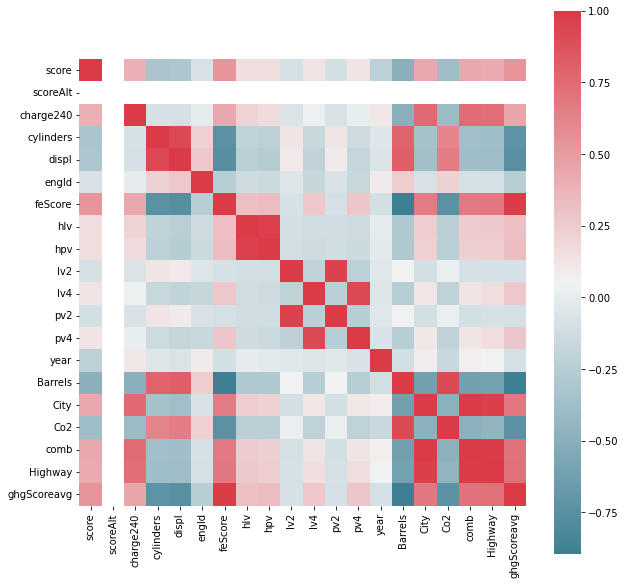

In [75]:
plt.figure(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.show()

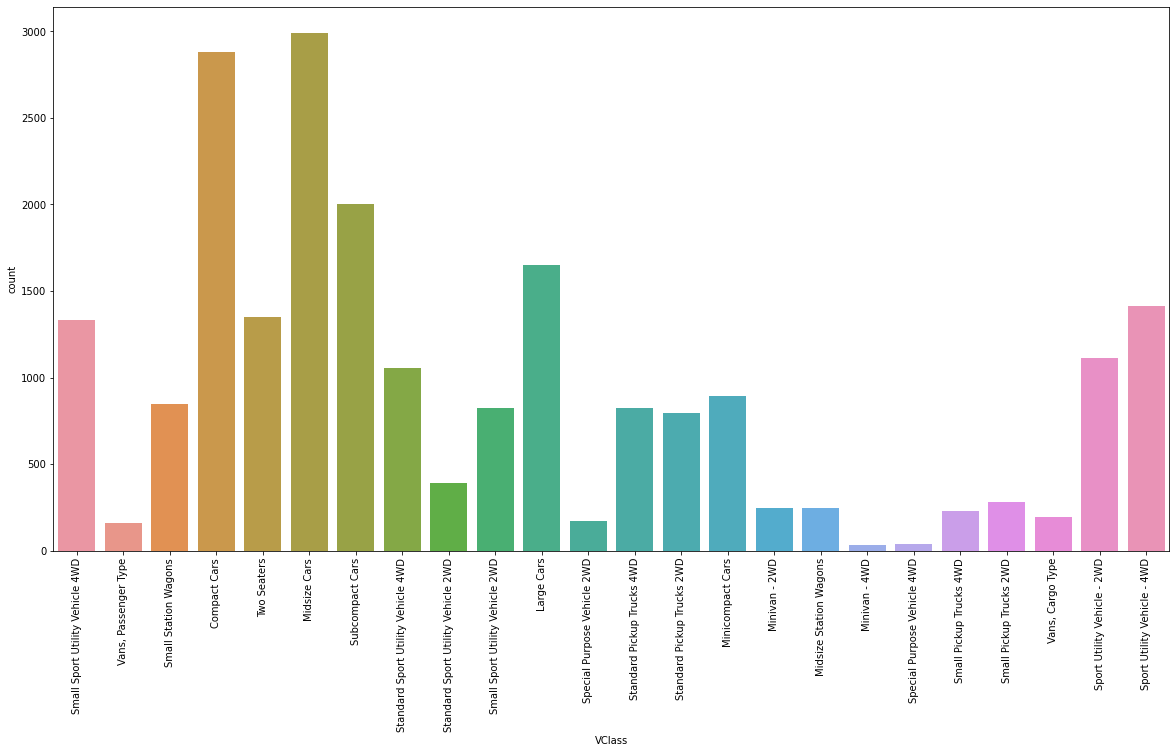

In [76]:
plt.figure(figsize=(20,10))
sns.countplot(data = df_raw, x = "VClass")
plt.xticks(rotation=90)
plt.show()

In [77]:
Score_1_df = df.loc[df["ghgScoreavg"] == 1]

In [78]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'charge240', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelType', 'hlv',
       'hpv', 'lv2', 'lv4', 'make', 'model', 'pv2', 'pv4', 'trany', 'VClass',
       'year', 'trans_dscr', 'atvType', 'startStop', 'Barrels', 'City', 'Co2',
       'comb', 'Highway', 'Charger', 'ghgScoreavg'],
      dtype='object')

<AxesSubplot:xlabel='cylinders', ylabel='count'>

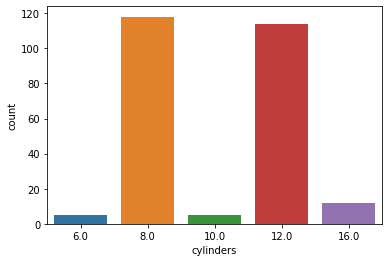

In [79]:
# Most of the veichle with a score of 10 have 8.0 cylinders or 12.0 cylinders 
sns.countplot(x = "cylinders", data = Score_1_df )

In [80]:
Score_10_df = df.loc[df["ghgScoreavg"] == 10]

<AxesSubplot:xlabel='cylinders', ylabel='count'>

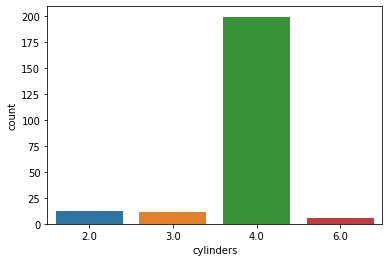

In [81]:
# Most of the veichle with a score of 10 has 4.0 cylinders 
sns.countplot(x = "cylinders", data = Score_10_df )

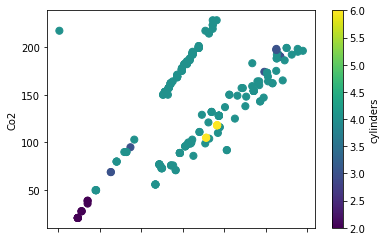

In [82]:
# The veichle with score 10 have a range between 2.0 and 6.0 cylindric  
Score_10_df.plot.scatter(x="Barrels", y="Co2", c = "cylinders", cmap="viridis", s=50);

<AxesSubplot:xlabel='Barrels', ylabel='Co2'>

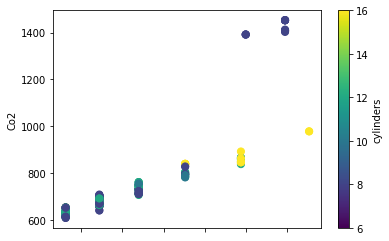

In [83]:
Score_1_df.plot.scatter(x="Barrels", y="Co2", c = "cylinders", cmap="viridis", s=50)

In [84]:
from pandas.plotting import parallel_coordinates

In [85]:
dfcolumnss = df[['year', 'Co2']]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

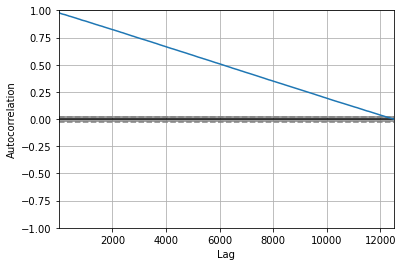

In [86]:
from pandas.plotting import autocorrelation_plot

plt.figure()

spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)

data = pd.Series(0.7 * np.random.rand(1000) + 0.3 * np.sin(spacing))

autocorrelation_plot(dfcolumnss)

In [87]:
dfcolumnss2 = Score_10_df[['year', 'Co2']]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

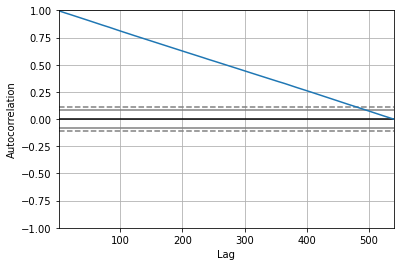

In [88]:
from pandas.plotting import autocorrelation_plot

plt.figure()

spacing = np.linspace(-9 * np.pi, 9 * np.pi, num=1000)

data = pd.Series(0.7 * np.random.rand(1000) + 0.3 * np.sin(spacing))

autocorrelation_plot(dfcolumnss2)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

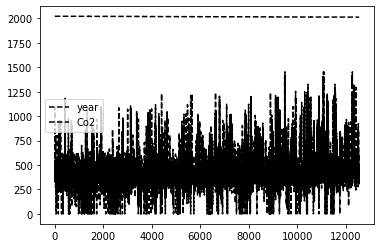

In [89]:
plt.figure();

dfcolumnss.plot(style="k--", label="Series")

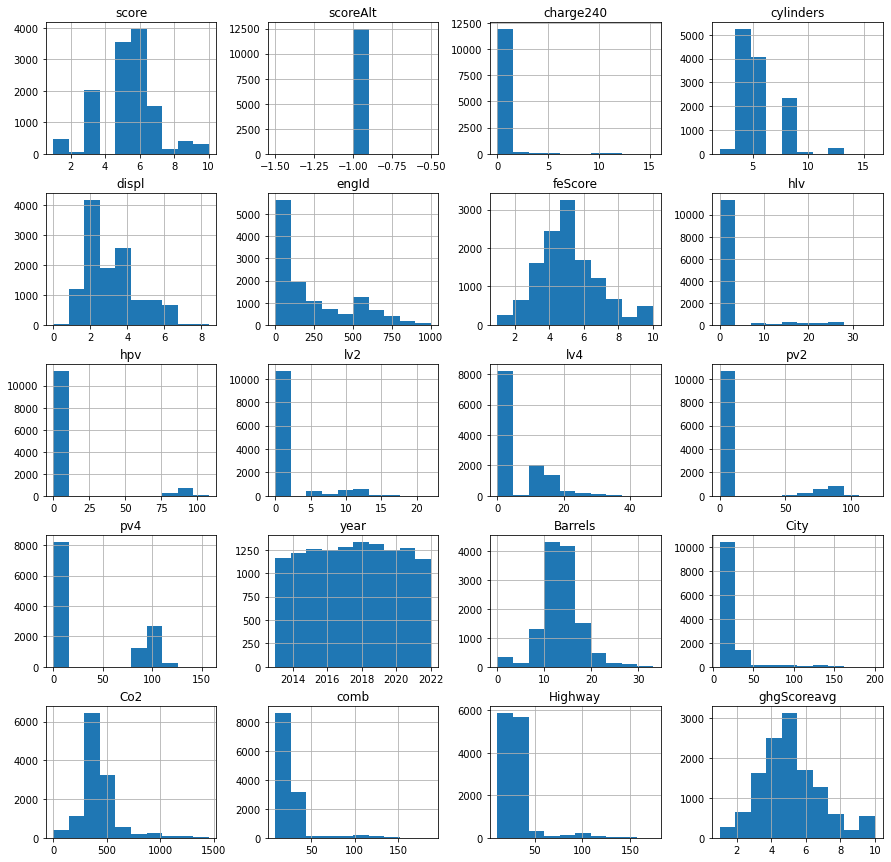

In [90]:
df.hist(figsize=(15,15))
plt.show()

In [94]:
df.dtypes

score          float64
scoreAlt       float64
standard        object
stdText         object
charge240      float64
cylinders      float64
displ          float64
drive           object
engId            int64
eng_dscr        object
feScore          int64
fuelType        object
hlv              int64
hpv              int64
lv2              int64
lv4              int64
make            object
model           object
pv2              int64
pv4              int64
trany           object
VClass          object
year             int64
trans_dscr      object
atvType         object
startStop       object
Barrels        float64
City             int64
Co2              int64
comb             int64
Highway          int64
Charger         object
ghgScoreavg    float64
dtype: object

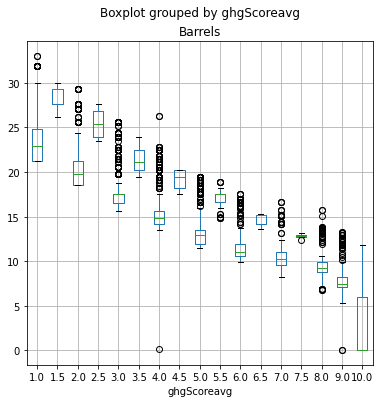

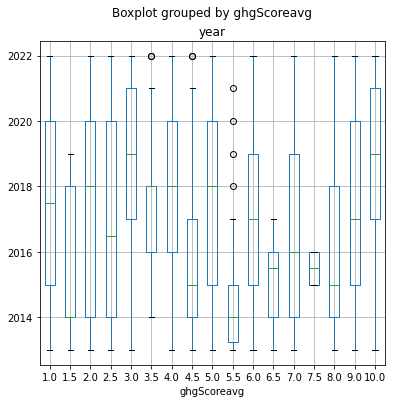

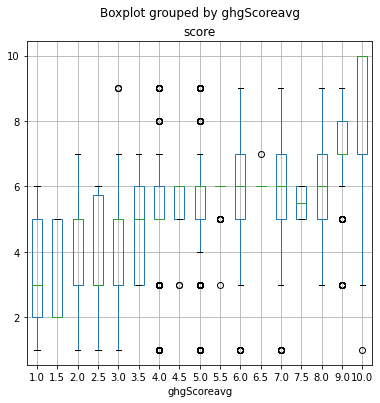

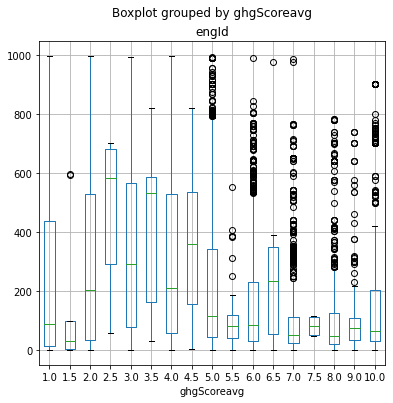

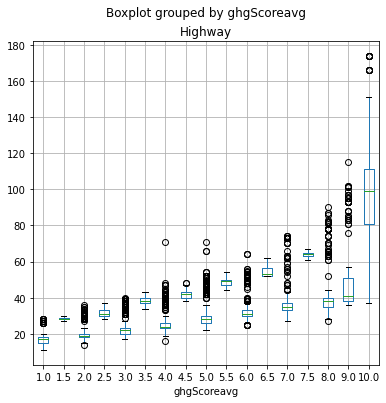

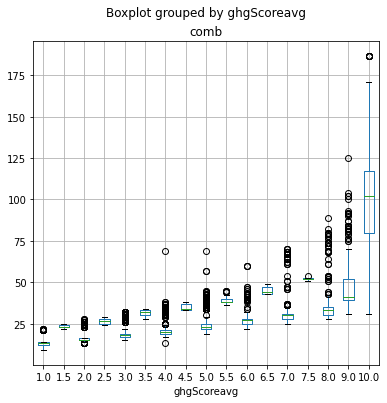

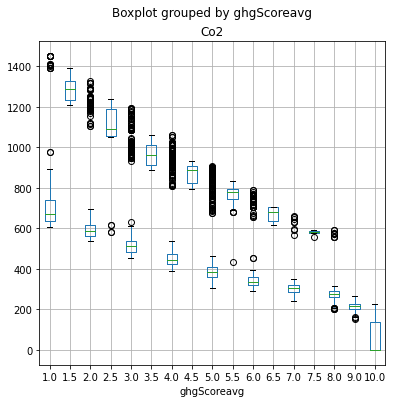

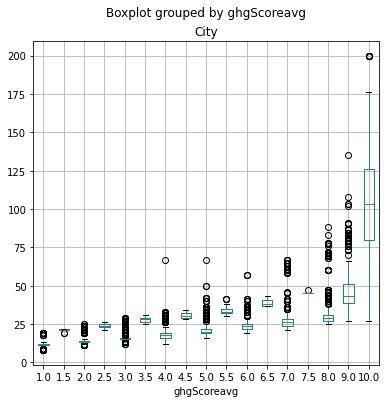

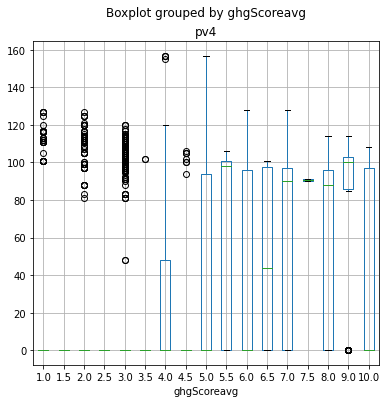

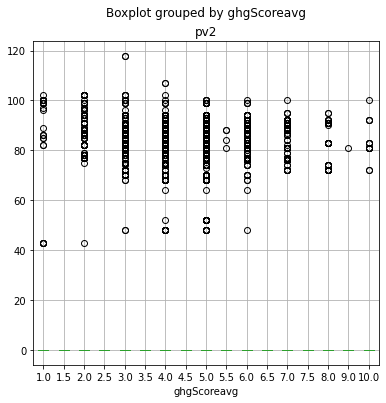

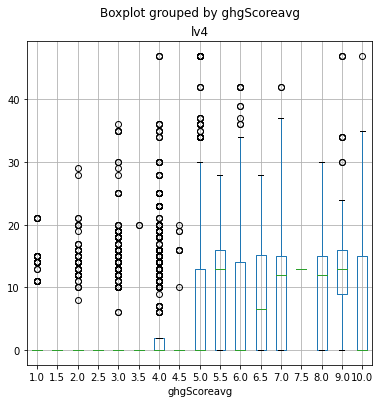

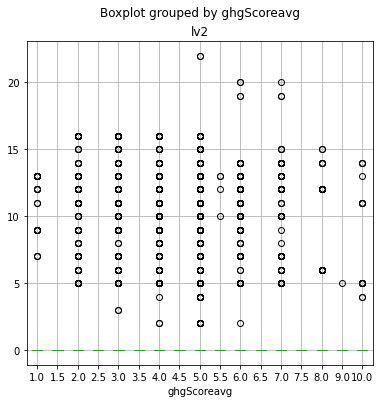

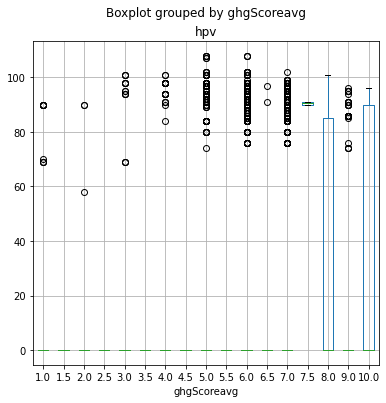

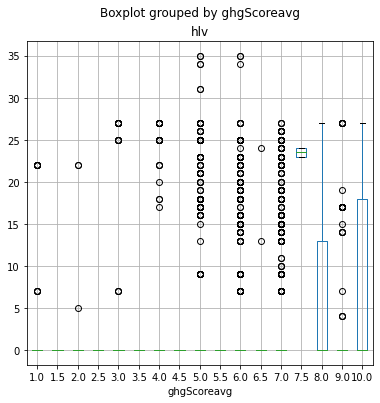

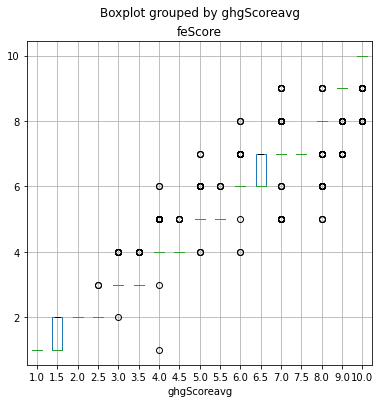

In [102]:
# The scores tends to have fairly clearly differentiated features between each others; which should help us train a good classification model.

score_features = ['Barrels','year',"score", "engId", "Highway","comb","Co2","City", "pv4", "pv2", "lv4", "lv2", "hpv", "hlv", "feScore"]
score_label = 'ghgScoreavg'
for col in score_features:
    df.boxplot(column=col, by=score_label, figsize=(6,6))
    plt.title(col)
plt.show()

In [ ]:
df.columns

### Transform the categorical features into Numerical

In [ ]:
df.dtypes

In [ ]:
df_backup = copy.deepcopy(df)

In [ ]:
train_cats(df)

In [ ]:
df.fuelType.cat.categories.tolist()

In [ ]:
df.fuelType.cat.categories

In [ ]:
df.fuelType.cat.codes

In [ ]:
#We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable 
#into a separate variable.
df, y, nas = proc_df(df, 'ghgScoreavg')

In [ ]:
df

In [ ]:
df.dtypes

In [ ]:
#ghgScore
y = [int(val) for val in y]
y

In [ ]:
#now all the variables are transformed into numerical 
df.dtypes

In [ ]:
print(df.shape)

The variable we want to predict is the ghgScore 

#It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need. -> from lecture 2 

In [ ]:
x = df
y 

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, stratify=y, test_size = 0.3,random_state = 42)

In [ ]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

y_predict_train_logreg = logreg.predict(x_train)
y_predict_test_logreg = logreg.predict(x_test)

train_accuracy_score_logreg = accuracy_score(y_train, y_predict_train_logreg)
test_accuracy_score_logreg = accuracy_score(y_test, y_predict_test_logreg)

print(train_accuracy_score_logreg)
print(test_accuracy_score_logreg)

In [ ]:
cm_logreg = confusion_matrix(y_test,y_predict_test_logreg)
draw_confusion_matrix(cm_logreg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=6, criterion = 'entropy', 
                            min_samples_leaf= 1,min_samples_split= 2)
rf.fit(x_train, y_train)

y_predict_train_rf = rf.predict(x_train)
y_predict_test_rf = rf.predict(x_test)

train_accuracy_score_rf = accuracy_score(y_train, y_predict_train_rf)
test_accuracy_score_rf = accuracy_score(y_test, y_predict_test_rf)

print(train_accuracy_score_rf)
print(test_accuracy_score_rf)

In [ ]:
cm_rf = confusion_matrix(y_test,y_predict_test_rf)
draw_confusion_matrix(cm_rf)

In [ ]:
classifier = RandomForestClassifier(
    n_estimators = 30, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 'auto', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)


In [ ]:
%time classifier.fit(x_train, y_train)

print(classifier.score(x_train, y_train)) # classification accuracy on training set
print(classifier.oob_score_) 

In [ ]:
def specificity_score(y_true, y_predict):
    '''
    Computes the proba that a label is 0 knowing that the prediction is 0
    '''
    y_predict_0  = [(pred, true) for pred, true in zip(y_predict, y_true) if true == 0]
    y_predict_00 = [(pred, true) for pred, true in y_predict_0 if pred == 0]
    specificity  = (0 if len(y_predict_0) == 0 else len(y_predict_00)/len(y_predict_0))
    return specificity

In [ ]:
y_predict_valid = classifier.predict(x_train)

acc = metrics.accuracy_score(y_train, y_predict_valid)
rec = metrics.recall_score(y_train, y_predict_valid, average = 'micro')
prc = metrics.precision_score(y_train, y_predict_valid, average = 'micro')
spe = specificity_score(y_train, y_predict_valid)
f1  = metrics.f1_score(y_train, y_predict_valid, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
y_predict_valid = classifier.predict(x_test)

acc = metrics.accuracy_score(y_test, y_predict_valid)
rec = metrics.recall_score(y_test, y_predict_valid, average = 'micro')
prc = metrics.precision_score(y_test, y_predict_valid, average = 'micro')
spe = specificity_score(y_test, y_predict_valid)
f1  = metrics.f1_score(y_test, y_predict_valid, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
y_predict_valid = rf.predict(x_train)

acc = metrics.accuracy_score(y_train, y_predict_valid)
rec = metrics.recall_score(y_train, y_predict_valid, average = 'micro')
prc = metrics.precision_score(y_train, y_predict_valid, average = 'micro')
spe = specificity_score(y_train, y_predict_valid)
f1  = metrics.f1_score(y_train, y_predict_valid, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
y_predict_valid = rf.predict(x_test)

acc = metrics.accuracy_score(y_test, y_predict_valid)
rec = metrics.recall_score(y_test, y_predict_valid, average = 'micro')
prc = metrics.precision_score(y_test, y_predict_valid, average = 'micro')
spe = specificity_score(y_test, y_predict_valid)
f1  = metrics.f1_score(y_test, y_predict_valid, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
numeric_cols = [cname for cname in x_train.columns if x_train[cname].dtype in ['int64', 'float64']]
X = x_train[numeric_cols].copy()

In [ ]:
print("Shape of input data: {} and shape of target variable: {}".format(x.shape, len(y)))


In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1
    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
score = cross_val_score(RandomForestClassifier(random_state= 42), x, y, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

In [ ]:
df.columns 